In [1]:
%matplotlib inline
import sys
sys.path.append('..')

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, AveragePooling1D, Dropout, Flatten
from keras.utils import to_categorical

Using TensorFlow backend.


In [98]:
from modules.factory import norm, fmeasure, recall, matthews_correlation
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, f1_score
from IPython.display import clear_output

### 0. Parameters

In [89]:
modelfile = '../data/keras models/20day-trend.h5'
rawfile = '../data/training set/daily-future-20day-3classes.h5'
savefile = '../data/keras models/20day-trend-prediction.h5'
seq_length = 120
trend_period = 20
num_classes = 2

### 1. Data Loading & Reconstruction

#### A. Constructing Data

In [7]:
f = h5py.File(rawfile, 'r')

In [8]:
FILES = shuffle([i[1] for i in f.items()], random_state=1)

In [91]:
%%time
X=[]
Y=[]
for idx,file in enumerate(FILES[30:40]):
    print('processing...(%s)'%idx)
    raw_data = pd.DataFrame(file.value, 
                            columns=['open','high','low','close','trend'])
    raw_data['ema5'] = raw_data.close/raw_data.close.ewm(span=5).mean()
    raw_data['ema20']= raw_data.close/raw_data.close.ewm(span=20).mean()
    raw_data['ema60']= raw_data.close/raw_data.close.ewm(span=60).mean()
    for i in range(len(raw_data)-seq_length-trend_period):
        seq_data = raw_data[i:i+seq_length]
        normed = norm(seq_data[['open','high','low','close']], ntype='zscore')
        normed['ema5'] = raw_data.ema5[i:i+seq_length]
        normed['ema20'] = raw_data.ema20[i:i+seq_length]
        normed['ema60'] = raw_data.ema60[i:i+seq_length]
        normed['trend'] = seq_data['trend']
    
        X.append(normed.values)
        Y.append(raw_data.trend.iloc[i+seq_length+trend_period]+1)
    clear_output(wait=True)
#X = np.array(X)
#Y = np.round(np.array(Y))
#X,Y = shuffle(X,Y)

Wall time: 2min 31s


In [92]:
X=np.array(X)
Y=np.array(Y)
#Y=np.where(np.array(Y)==2, 1, 0)
Y = to_categorical(Y)
X,Y = shuffle(X,Y)

In [85]:
x_train, y_train = X,Y

In [61]:
# seperate into train and test data
length = int(len(X) * 0.7)
x_train, x_test = X[:length], X[length:]
y_train, y_test = Y[:length], Y[length:]

In [50]:
Counter(y_test)

Counter({0.0: 1267, 1.0: 3290, 2.0: 1976})

### 2. Build a Model

In [51]:
model = Sequential()
model.add(Conv1D(32, 4, input_shape=X.shape[1:], activation='relu'))
model.add(AveragePooling1D(pool_size=4))
model.add(Conv1D(64, 4, activation='relu'))
model.add(AveragePooling1D(pool_size=4))

model.add(Dropout(0.25))
model.add(LSTM(128, 
               return_sequences=False,
               dropout=0.2, recurrent_dropout=0.2))

In [52]:
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = [matthews_correlation, recall, fmeasure])

### 3. Training

In [109]:
history = model.fit(x_train, y_train, epochs=40, batch_size=16, verbose=1, class_weight={0:1.5,1:1,2:1.5})

Epoch 1/40
65089/65089 [==============================] - 85s - loss: 0.7140 - matthews_correlation: 0.6232 - recall: 0.7162 - fmeasure: 0.7424    
Epoch 2/40
46576/65089 [====================>.........] - ETA: 24s - loss: 0.7005 - matthews_correlation: 0.6319 - recall: 0.7243 - fmeasure: 0.7487

KeyboardInterrupt: 

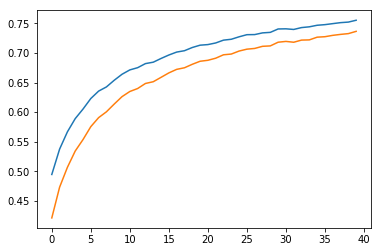

In [87]:
plt.plot(history.history['fmeasure'])
plt.plot(history.history['recall'])

In [102]:
score = model.evaluate(X, Y, batch_size=10)
print('\nTest score:', score)

22800/22883 [============================>.] - ETA: 0s
Test score: [1.3551180605855442, 0.22894197343342143, 0.45535988102870162, 0.47352272065292311]


In [90]:
model.save(savefile)

### 4. Verification - ROC curve

In [93]:
predic = model.predict(X, verbose=1)

22848/22883 [============================>.] - ETA: 0s

In [94]:
predic

array([[  5.20471986e-07,   1.29842653e-03,   9.98700976e-01],
       [  3.19589317e-01,   6.78252637e-01,   2.15810584e-03],
       [  1.89306170e-01,   7.26931572e-01,   8.37621838e-02],
       ..., 
       [  1.10514872e-02,   9.10626352e-01,   7.83222467e-02],
       [  1.88137919e-01,   5.74781477e-01,   2.37080544e-01],
       [  4.37954161e-03,   1.85808346e-01,   8.09812129e-01]], dtype=float32)

In [95]:
Counter(predic.argmax(axis=-1))

Counter({0: 3583, 1: 13541, 2: 5759})

In [97]:
Counter(Y.argmax(axis=-1))

Counter({0: 5060, 1: 11128, 2: 6695})

In [100]:
f1_score(Y.argmax(axis=-1),predic.argmax(axis=-1) , average='macro') 

0.43458223879531827

In [101]:
f1_score(Y.argmax(axis=-1),predic.argmax(axis=-1) , average='micro') 

0.48682428003321243

In [103]:
f1_score(Y.argmax(axis=-1),predic.argmax(axis=-1) , average='weighted') 

0.47399915303716927

In [75]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, predic, pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: bad input shape (6533, 3)

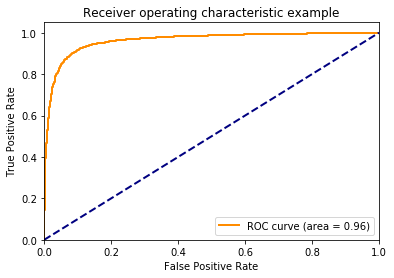

In [229]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 5. Verification - Real Data

In [76]:
import time

Predic:  [ 0.03744295  0.78669232  0.17586479]
Predic: 0
Real:  1.0


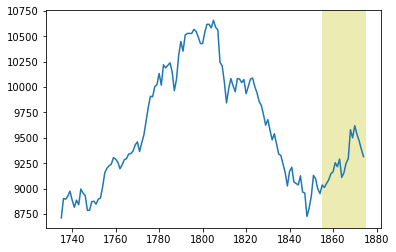

q


In [108]:
while True:
    file = np.random.choice(FILES[30:])
    raw_data = pd.DataFrame(file.value, 
                            columns=['open','high','low','close','trend'])
    raw_data['ema5'] = raw_data.close/raw_data.close.ewm(span=5).mean()
    raw_data['ema20']= raw_data.close/raw_data.close.ewm(span=20).mean()
    raw_data['ema60']= raw_data.close/raw_data.close.ewm(span=60).mean()

    start = np.random.randint(0, len(raw_data)-seq_length-trend_period)
    endseq = start + seq_length
    endtrend = endseq + trend_period
    
    seq_data = raw_data[start:endseq]
    normed = norm(seq_data[['open','high','low','close']], ntype='zscore')
    normed['ema5'] = raw_data.ema5[start:endseq]
    normed['ema20'] = raw_data.ema20[start:endseq]
    normed['ema60'] = raw_data.ema60[start:endseq]
    normed['trend'] = seq_data['trend']
    predic = model.predict(np.array([normed.values]))[0]
    
    print("Predic: ", predic)
    print("Predic:", predic.argmax()-1)
    print("Real: ", raw_data.trend.iloc[endtrend])
    
    plt.figure()
    plt.plot(raw_data.close[start:endtrend])
    plt.axvspan(endseq,endtrend, facecolor='y', alpha=0.3)
    plt.show()
    #fig, (ax) = plt.subplots(1,2, figsize=(20,5))
    
    #ax[0].plot(test_x[i,:,3])
    #ax[1].plot(test_x[i+60,:,3])
    #ax[1].axvspan(120,180, facecolor='y', alpha=0.3 )
    #plt.show()
    #time.sleep(0.1)
    key = input()
    if key == 'q':
        break
    clear_output(wait=True)

In [157]:
model.predict(np.array([normed.values]))

array([[ nan]], dtype=float32)

In [161]:
raw_data.ema5[i:i+seq_length]

2476   -0.028168
2477   -0.015298
2478   -0.014285
2479   -0.016515
2480   -0.031580
2481   -0.015440
2482   -0.032011
2483   -0.028934
2484   -0.035966
2485   -0.038785
2486   -0.026023
2487   -0.013154
2488   -0.028626
2489    0.003274
2490   -0.012871
2491    0.006342
2492   -0.006021
2493   -0.013066
2494   -0.018007
2495   -0.007807
2496   -0.012278
Name: ema5, dtype: float64

In [109]:
pd.ewma(raw_data.close, span=10).mean()

C:\Python\Miniconda64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=10,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


3.33612269013754

In [111]:
raw_data['ema'] = raw_data.close.ewm(span=10).mean()

In [112]:
raw_data

,open,high,low,close,downtrend,uptrend,ema
0,1.4960,1.4980,1.4740,1.4870,2.739136e-04,8.848447e-01,1.487000
1,1.4890,1.4900,1.4570,1.4645,1.595031e-05,5.139159e-03,1.474625
2,1.4540,1.4630,1.4270,1.4595,1.839598e-04,8.178793e-01,1.468545
3,1.4560,1.4590,1.4390,1.4465,2.277036e-04,7.696805e-03,1.461282
4,1.4530,1.4720,1.4500,1.4595,9.120651e-04,4.928198e-05,1.460770
5,1.4570,1.4650,1.4440,1.4590,7.089793e-06,1.495185e-06,1.460311
6,1.4530,1.4580,1.4420,1.4580,3.719399e-04,1.358987e-07,1.459754
7,1.4670,1.4990,1.4550,1.4960,1.779208e-03,1.010162e-06,1.468000
8,1.4890,1.4950,1.4790,1.4935,9.425099e-07,2.659535e-06,1.473548
9,1.4970,1.5190,1.4960,1.5105,6.485791e-06,3.234991e-05,1.481310
